<a href="https://colab.research.google.com/github/apchavezr/19.-Procesamiento-del-Lenguaje-Natural/blob/main/NaiveBayes_Spam_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# laboratorio: clasificación de spam con Naive Bayes (español)

**Objetivo:** entrenar y evaluar un clasificador de correos *spam* vs *no_spam* usando **Multinomial Naive Bayes** con **TF‑IDF**, comparar con/sin *stopwords*, interpretar métricas y probar con mensajes nuevos.

**Requisitos:** Python 3.9+, scikit-learn, pandas, numpy, matplotlib.

> Este notebook fue generado automáticamente para práctica docente. Puede modificar el dataset y repetir los experimentos.



## contenidos y resultados de aprendizaje

1. crear un mini dataset sintético (10 spam y 10 no_spam).
2. dividir en *train/test* estratificado.
3. construir *pipelines* con `TfidfVectorizer` + `MultinomialNB`.
4. entrenar dos variantes: **con** y **sin** *stopwords* personalizadas.
5. evaluar con **accuracy**, **precision**, **recall**, **F1** y **matriz de confusión**.
6. predecir correos nuevos y analizar errores.
7. ejercicios guiados para experimentar con n‑gramas y *stopwords*.


In [1]:

# instalar dependencias si hace falta (en Colab se puede usar pip)
# !pip install scikit-learn pandas matplotlib --quiet

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt



## 1. crear el dataset sintético

El dataset contiene 20 correos (10 spam y 10 no_spam). Modifique los textos para acercarlos a su contexto.


In [2]:

spam_texts = [
    "gana dinero rápido con esta promoción exclusiva hoy",
    "oferta limitada: crédito aprobado sin revisar historial",
    "haz clic aquí para reclamar tu premio urgente",
    "último aviso: transfiere ahora y duplica tu inversión",
    "promoción especial de préstamos inmediatos sin interés",
    "recibe un bono gratis registrándote en este enlace",
    "felicitaciones, has sido seleccionado para un premio exclusivo",
    "compra ahora y obtén un cupón de descuento del 80 por ciento",
    "evita cargos: actualiza tu cuenta bancaria urgente",
    "trabajo desde casa: ingresos garantizados sin experiencia",
]

ham_texts = [
    "reunión confirmada para mañana a las 10 am",
    "adjunto el informe de ventas del mes pasado",
    "recordatorio: clase de análisis de datos a las 6 pm",
    "la entrega del proyecto se movió para el viernes",
    "gracias por su ayuda con el reporte financiero",
    "favor revisar el borrador y enviar comentarios",
    "hoy tendremos mantenimiento de la plataforma",
    "¿puede confirmar la disponibilidad de la sala?",
    "comparto la agenda de la semana con los pendientes",
    "nota: el proveedor confirmó el despacho para el martes",
]

df = pd.DataFrame({
    "texto": spam_texts + ham_texts,
    "etiqueta": ["spam"] * len(spam_texts) + ["no_spam"] * len(ham_texts)
})
df.sample(5, random_state=0)  # vista rápida


,texto,etiqueta
18,comparto la agenda de la semana con los pendie...,no_spam
1,oferta limitada: crédito aprobado sin revisar ...,spam
19,nota: el proveedor confirmó el despacho para e...,no_spam
8,evita cargos: actualiza tu cuenta bancaria urg...,spam
10,reunión confirmada para mañana a las 10 am,no_spam



## 2. partición entrenamiento/prueba

Se usa estratificación para mantener el balance de clases en ambos subconjuntos.


In [3]:

X_train, X_test, y_train, y_test = train_test_split(
    df["texto"],
    df["etiqueta"],
    test_size=0.3,
    random_state=42,
    stratify=df["etiqueta"]
)

len(X_train), len(X_test), y_train.value_counts(), y_test.value_counts()


(14,
 6,
 etiqueta
 spam       7
 no_spam    7
 Name: count, dtype: int64,
 etiqueta
 no_spam    3
 spam       3
 Name: count, dtype: int64)


## 3. *stopwords* personalizadas (español)

Para ilustrar el consejo didáctico, se incluye una lista básica de palabras de alta frecuencia. Añada o quite términos y observe el impacto.


In [4]:

spanish_custom = [
    "el","la","los","las","un","una","unos","unas","de","del","al",
    "a","y","o","u","que","como","en","por","para","con","sin","su",
    "sus","es","son","fue","ser","se","ya","no","si","sí","lo","le",
    "les","esto","esta","estas","estos","eso","esa","esas","esos",
    "mi","mis","tu","tus","nuestro","nuestra","nuestros","nuestras",
    "hoy","mañana","ayer","muy","más","menos","también","pero","porque",
    "donde","cuando","quien","quién","cual","cuál","cuales","cuáles"
]



## 4. *pipelines* (TF‑IDF + MultinomialNB)

Se construyen dos variantes para comparar:  
- **con_stop**: TF‑IDF con *stopwords* personalizadas y bigramas.  
- **sin_stop**: TF‑IDF sin *stopwords* y con bigramas.


In [5]:

pipe_con_stop = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words=spanish_custom, ngram_range=(1,2))),
    ("nb", MultinomialNB())
])

pipe_sin_stop = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2))),
    ("nb", MultinomialNB())
])



## 5. entrenamiento y evaluación

Se imprimen **accuracy**, **matriz de confusión** y **reporte de clasificación** para cada variante.


In [6]:

def entrenar_y_evaluar(pipe, nombre):
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    cm = confusion_matrix(y_test, preds, labels=["spam","no_spam"])
    print("="*80)
    print(f"Modelo: {nombre}")
    print(f"Accuracy: {acc:.3f}")
    print("Matriz de confusión (filas=verdad, columnas=predicción):")
    print(pd.DataFrame(cm, index=["spam","no_spam"], columns=["spam","no_spam"]))
    print("\nReporte de clasificación:\n", classification_report(y_test, preds, target_names=["spam","no_spam"]))
    return pipe, preds, cm, acc

modelo_con_stop, preds1, cm1, acc1 = entrenar_y_evaluar(pipe_con_stop, "Naive Bayes + TF-IDF con stopwords + bigramas")
modelo_sin_stop, preds2, cm2, acc2 = entrenar_y_evaluar(pipe_sin_stop, "Naive Bayes + TF-IDF sin stopwords + bigramas")


Modelo: Naive Bayes + TF-IDF con stopwords + bigramas
Accuracy: 0.667
Matriz de confusión (filas=verdad, columnas=predicción):
         spam  no_spam
spam        1        2
no_spam     0        3

Reporte de clasificación:
               precision    recall  f1-score   support

        spam       0.60      1.00      0.75         3
     no_spam       1.00      0.33      0.50         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6

Modelo: Naive Bayes + TF-IDF sin stopwords + bigramas
Accuracy: 0.833
Matriz de confusión (filas=verdad, columnas=predicción):
         spam  no_spam
spam        2        1
no_spam     0        3

Reporte de clasificación:
               precision    recall  f1-score   support

        spam       0.75      1.00      0.86         3
     no_spam       1.00      0.67      0.80         3

    accuracy                           0.83         6
   macr


## 6. visualización de la matriz de confusión

Se grafica la matriz de confusión del mejor modelo (por *accuracy*). No se especifican colores explícitos.


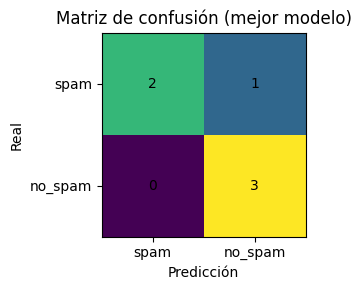

In [7]:

best_cm = cm1 if acc1 >= acc2 else cm2
fig = plt.figure(figsize=(4,3))
plt.imshow(best_cm, interpolation='nearest')
plt.title("Matriz de confusión (mejor modelo)")
plt.xticks([0,1], ["spam","no_spam"])
plt.yticks([0,1], ["spam","no_spam"])
for i in range(best_cm.shape[0]):
    for j in range(best_cm.shape[1]):
        plt.text(j, i, str(best_cm[i, j]), ha="center", va="center")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()



## 7. predicción en correos nuevos

Escriba sus propios ejemplos y observe resultados en ambas variantes.


In [8]:

nuevos = [
    "obtén tu premio gratis haciendo clic aquí",
    "comparto el acta de la reunión de hoy",
    "urgente: su cuenta requiere verificación para evitar cargos",
    "se adjunta la factura del servicio del mes",
    "promoción exclusiva: crédito inmediato sin interés"
]

print("Predicciones (con stopwords personalizadas):")
for t in nuevos:
    print(f"- {t} -> {modelo_con_stop.predict([t])[0]}")

print("\nPredicciones (sin stopwords):")
for t in nuevos:
    print(f"- {t} -> {modelo_sin_stop.predict([t])[0]}")


Predicciones (con stopwords personalizadas):
- obtén tu premio gratis haciendo clic aquí -> spam
- comparto el acta de la reunión de hoy -> no_spam
- urgente: su cuenta requiere verificación para evitar cargos -> spam
- se adjunta la factura del servicio del mes -> no_spam
- promoción exclusiva: crédito inmediato sin interés -> spam

Predicciones (sin stopwords):
- obtén tu premio gratis haciendo clic aquí -> spam
- comparto el acta de la reunión de hoy -> no_spam
- urgente: su cuenta requiere verificación para evitar cargos -> spam
- se adjunta la factura del servicio del mes -> no_spam
- promoción exclusiva: crédito inmediato sin interés -> spam



## 8. ejercicios guiados

1. **n‑gramas:** cambie `ngram_range=(1,2)` a `(1,1)` y luego `(1,3)`. Compare métricas.
2. **stopwords:** añada palabras como *“urgente”* o *“gratis”* a la lista. Observe cómo cambian *precision* y *recall* de la clase *spam*.
3. **dataset:** duplique el tamaño del corpus creando nuevas frases realistas (colombianismos, bancos locales, términos administrativos). Evalúe si el *accuracy* mejora.
4. **validación:** aumente `test_size` a `0.4` y repita. ¿Qué pasa con la estabilidad de las métricas?
5. **errores:** identifique mensajes mal clasificados e intente reformularlos para entender qué términos confunden al modelo.



## 9. guardar dataset para reutilizar

Se guarda un CSV para compartir o usar desde un script `.py`.


In [ ]:

os.makedirs("data", exist_ok=True)
df.to_csv("data/dataset_spam_es.csv", index=False, encoding="utf-8")
print("Guardado:", os.path.abspath("data/dataset_spam_es.csv"))
